In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cnx = sqlite3.connect('Database/Civ6CitySettledData.db')
cur = cnx.cursor()
print(cnx)
print(cur)

## Retrieve the city growth and performance data
cityPerTurnView contains all the relevant data captured for each city per turn of the game. I align the number of turns the city has existed so we can make an elapsed turn based evaluation.

The base identiy for this database is the cityId. That is, in this database (and experiment) is designed to look at city growth over time. The same cityName can occur in multiple games so when we add the recorded information for the game we create new cityIds.

In [3]:
sqlSelect = 'SELECT * FROM cityPerTurnView WHERE turns >= 1 and turns <= 50'
cityPt = pd.read_sql_query(sqlSelect, cnx)
# Did the following directly in the database query ;-)
#cptv = cptv[cptv['turns'].between(1, 50, inclusive=True)]
print(cityPt.shape)
print(cityPt.dtypes)

(4900, 29)
cityId                 int64
gameId                 int64
settledById            int64
currentOwnerId         int64
cityName              object
settledByName         object
settledByCiv          object
currentOwnerName      object
currentOwnerCiv       object
settledOnTurn          int64
gameTurn               int64
turns                  int64
foodPerTurn          float64
foodToolTip           object
productionPerTurn    float64
productionToolTip     object
goldPerTurn          float64
goldToolTip           object
sciencePerTurn       float64
scienceToolTip        object
culturePerTurn       float64
cultureToolTip        object
faithPerTurn         float64
faithToolTip          object
population             int64
housing                int64
amenities              int64
amenitiesNeeded        int64
happiness             object
dtype: object


In [ ]:
#Miscellaneous bits of code while exploring and no longer used...

#df = cityPt[['cityId', 'turns', 'foodPerTurn']]
#print(df.shape)
#print(df.head())

#dfFoodCumulative = df.pivot(index='turns', columns='cityId', values='foodPerTurn').cumsum()
#print(dfFoodCumulative.shape)
#print(dfFoodCumulative.head())

#foodT50 = dfFoodCumulative.loc[50]
#axes[2].set_title("Statistics...")
#axes[2].annotate("max: {:.2f}".format(foodT50.max()),
#                xy=(.35, .78), xycoords=axes[2].transAxes)
#axes[2].annotate("min: {:.2f}".format(foodT50.min()),
#                xy=(.36, .70), xycoords=axes[2].transAxes)
#axes[2].annotate("mean: {:.2f}".format(foodT50.mean()),
#                xy=(.32, .62), xycoords=axes[2].transAxes)
#axes[2].annotate("median: {:.2f}".format(foodT50.median()),
#                xy=(.285, .54), xycoords=axes[2].transAxes)
#axes[2].annotate("std: {:.2f}".format(foodT50.std()),
#                xy=(.38, .46), xycoords=axes[2].transAxes)
#axes[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#axes[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

#tmp1 = cityPt[(cityPt['cityId'] == 1) & (cityPt['turns'] == 50)].foodToolTip.values
#print(tmp1)

## Food


Food:-
summary statistics:
     max: 736.00
     min: 194.00
    mean: 420.01
  median: 417.50
     std: 126.92

Quantiles:
      0.2    0.4    0.6    0.8
50  293.8  383.0  449.2  510.0




C:\Users\leon\Miniconda3\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


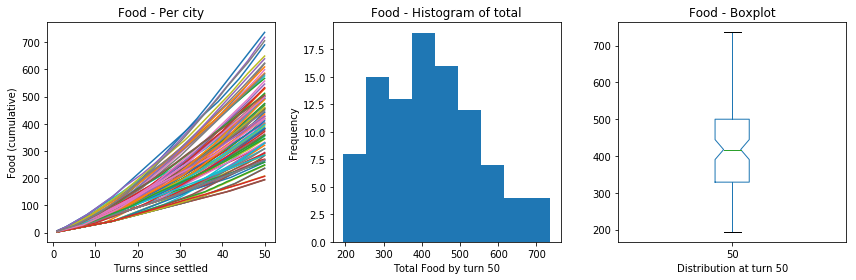


Top 5 food cities:
        foodTotal  foodPerTurn settledByName  population  housing   happiness  \
cityId                                                                          
41          736.0         20.0        Muscat           7        8  Displeased   
95          718.0         21.0       Gitarja           7        8  Displeased   
98          705.0         21.0        Trajan           6        9       Happy   
91          690.0         21.0     Jerusalem           6        9     Content   
69          649.0         16.0       Lautaro           5        8  Displeased   

                                              foodToolTip  
cityId                                                     
41                                  +20 from Worked Tiles  
95      +20 from Worked Tiles[NEWLINE]+1 from Building...  
98      +19 from Worked Tiles[NEWLINE]+1 from Building...  
91      +20 from Worked Tiles[NEWLINE]+1 from Building...  
69      +15 from Worked Tiles[NEWLINE]+1 from Buildi

In [4]:
#yields=['Food', 'Production', 'Gold', 'Science', 'Culture', 'Faith']
yld = 'Food'
columnName = "{}PerTurn".format(yld.lower())
cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                             columns='cityId',
                                                             values=columnName).cumsum()
t50 = cumulativeDf.loc[50]

print("\n{}:-\nsummary statistics:".format(yld))
print("     max: {:.2f}".format(t50.max()))
print("     min: {:.2f}".format(t50.min()))
print("    mean: {:.2f}".format(t50.mean()))
print("  median: {:.2f}".format(t50.median()))
print("     std: {:.2f}".format(t50.std()))
print("\nQuantiles:")
print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
print("\n")

top5 = pd.DataFrame(list(zip(list(t50.nlargest(5).values),
                             list(t50.nlargest(5).index.values)
                        )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
bottom5 = pd.DataFrame(list(zip(list(t50.nsmallest(5).values),
                                list(t50.nsmallest(5).index.values)
                           )
                      ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
axes[0].set_xlabel('Turns since settled')
axes[0].set_ylabel("{} (cumulative)".format(yld))

t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
axes[1].set_xlabel("Total {} by turn 50".format(yld))

t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
axes[2].set_xlabel('Distribution at turn 50')

plt.show()
plt.close()

# Redefining t50 to be the last per turn rows in the dataframe!
t50 = cityPt[cityPt['turns'] == 50]
tCitiesDf = top5.set_index('cityId').join(t50.set_index('cityId'))
bCitiesDf = bottom5.set_index('cityId').join(t50.set_index('cityId'))

yld = yld.lower()
print("\nTop 5 {} cities:".format(yld))
print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
print("\n\nBottom 5 {} cities:".format(yld))
print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Production


Production:-
summary statistics:
     max: 721.20
     min: 76.95
    mean: 292.09
  median: 202.05
     std: 174.83

Quantiles:
       0.2     0.4     0.6     0.8
50  144.85  176.23  250.28  488.65




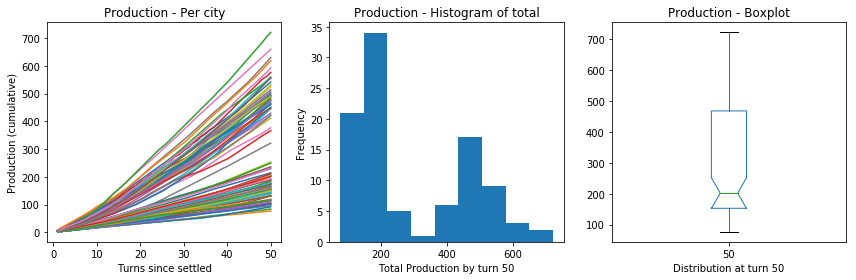


Top 5 production cities:
        productionTotal  productionPerTurn         settledByName  population  \
cityId                                                                         
83               721.20              17.25  Frederick Barbarossa           5   
67               660.20              14.40              Pericles           4   
68               630.35              17.50          Genghis Khan           4   
82               618.80              16.80               Tomyris           6   
97               592.80              17.25          Genghis Khan           5   

        housing   happiness                                  productionToolTip  
cityId                                                                          
83           10  Displeased  +12 from Worked Tiles[NEWLINE]+2 from Building...  
67            8     Content  +7 from Worked Tiles[NEWLINE]+2 from Buildings...  
68            8       Happy  +9 from Worked Tiles[NEWLINE]+2 from Buildings...  
82      

In [5]:
#yields=['Food', 'Production', 'Gold', 'Science', 'Culture', 'Faith']
yld = 'Production'
columnName = "{}PerTurn".format(yld.lower())
cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                             columns='cityId',
                                                             values=columnName).cumsum()
t50 = cumulativeDf.loc[50]

print("\n{}:-\nsummary statistics:".format(yld))
print("     max: {:.2f}".format(t50.max()))
print("     min: {:.2f}".format(t50.min()))
print("    mean: {:.2f}".format(t50.mean()))
print("  median: {:.2f}".format(t50.median()))
print("     std: {:.2f}".format(t50.std()))
print("\nQuantiles:")
print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
print("\n")

top5 = pd.DataFrame(list(zip(list(t50.nlargest(5).values),
                             list(t50.nlargest(5).index.values)
                        )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
bottom5 = pd.DataFrame(list(zip(list(t50.nsmallest(5).values),
                                list(t50.nsmallest(5).index.values)
                           )
                      ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
axes[0].set_xlabel('Turns since settled')
axes[0].set_ylabel("{} (cumulative)".format(yld))

t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
axes[1].set_xlabel("Total {} by turn 50".format(yld))

t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
axes[2].set_xlabel('Distribution at turn 50')

plt.show()
plt.close()

# Redefining t50 to be the last per turn rows in the dataframe!
t50 = cityPt[cityPt['turns'] == 50]
tCitiesDf = top5.set_index('cityId').join(t50.set_index('cityId'))
bCitiesDf = bottom5.set_index('cityId').join(t50.set_index('cityId'))

yld = yld.lower()
print("\nTop 5 {} cities:".format(yld))
print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
print("\n\nBottom 5 {} cities:".format(yld))
print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Gold


Gold:-
summary statistics:
     max: 731.20
     min: 246.75
    mean: 338.82
  median: 289.65
     std: 120.75

Quantiles:
       0.2      0.4     0.6     0.8
50  256.95  266.426  307.15  391.71




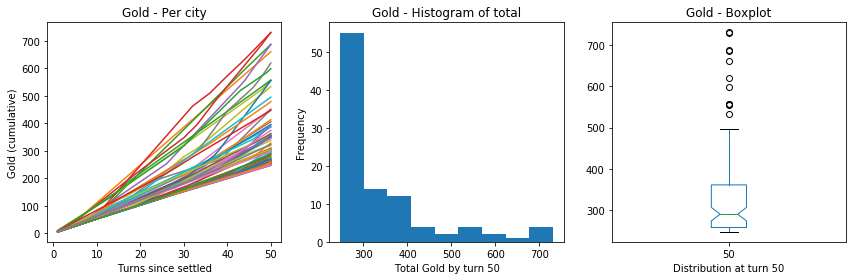


Top 5 gold cities:
        goldTotal  goldPerTurn    settledByName  population  housing  \
cityId                                                                 
24         731.20        21.25  Harald Hardrada           2        6   
54         730.20        16.25       Poundmaker           5        6   
23         687.80        16.25         Seondeok           5        7   
25         687.05        21.60           Trajan           5        7   
2          660.70        13.75        Montezuma           4        8   

       happiness                                        goldToolTip  
cityId                                                               
24         Happy  +5 from Buildings[NEWLINE]   +5 from Palace[NE...  
54         Happy  +1 from Worked Tiles[NEWLINE]+5 from Buildings...  
23         Happy  +5 from Buildings[NEWLINE]   +5 from Palace[NE...  
25       Content  +5 from Buildings[NEWLINE]   +5 from Palace[NE...  
2          Happy  +6 from Worked Tiles[NEWLINE]+5 from 

In [6]:
#yields=['Food', 'Production', 'Gold', 'Science', 'Culture', 'Faith']
yld = 'Gold'
columnName = "{}PerTurn".format(yld.lower())
cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                             columns='cityId',
                                                             values=columnName).cumsum()
t50 = cumulativeDf.loc[50]

print("\n{}:-\nsummary statistics:".format(yld))
print("     max: {:.2f}".format(t50.max()))
print("     min: {:.2f}".format(t50.min()))
print("    mean: {:.2f}".format(t50.mean()))
print("  median: {:.2f}".format(t50.median()))
print("     std: {:.2f}".format(t50.std()))
print("\nQuantiles:")
print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
print("\n")

top5 = pd.DataFrame(list(zip(list(t50.nlargest(5).values),
                             list(t50.nlargest(5).index.values)
                        )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
bottom5 = pd.DataFrame(list(zip(list(t50.nsmallest(5).values),
                                list(t50.nsmallest(5).index.values)
                           )
                      ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
axes[0].set_xlabel('Turns since settled')
axes[0].set_ylabel("{} (cumulative)".format(yld))

t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
axes[1].set_xlabel("Total {} by turn 50".format(yld))

t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
axes[2].set_xlabel('Distribution at turn 50')

plt.show()
plt.close()

# Redefining t50 to be the last per turn rows in the dataframe!
t50 = cityPt[cityPt['turns'] == 50]
tCitiesDf = top5.set_index('cityId').join(t50.set_index('cityId'))
bCitiesDf = bottom5.set_index('cityId').join(t50.set_index('cityId'))

yld = yld.lower()
print("\nTop 5 {} cities:".format(yld))
print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
print("\n\nBottom 5 {} cities:".format(yld))
print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Science


Science:-
summary statistics:
     max: 331.38
     min: 150.22
    mean: 190.10
  median: 182.24
     std: 31.27

Quantiles:
        0.2      0.4      0.6      0.8
50  166.176  175.856  191.066  203.816




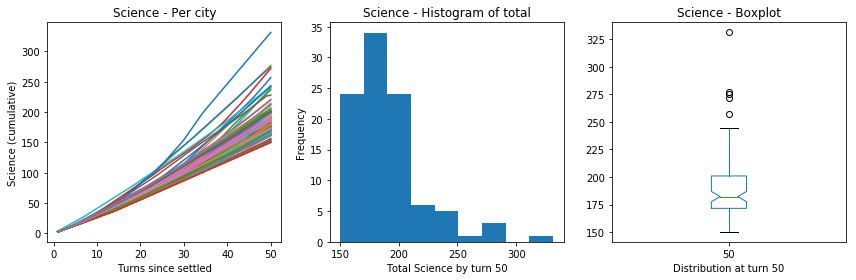


Top 5 science cities:
        scienceTotal  sciencePerTurn    settledByName  population  housing  \
cityId                                                                       
71            331.38            8.47        Gilgamesh           3        6   
19            277.52            7.02            Peter           5        7   
51            275.01            6.48  Teddy Roosevelt           4        6   
54            272.07            8.47       Poundmaker           5        6   
21            256.87            8.47       Wilhelmina           3        7   

       happiness                                     scienceToolTip  
cityId                                                               
71         Happy  +4 from Worked Tiles[NEWLINE]+2 from Buildings...  
19       Content  +2 from Buildings[NEWLINE]   +2 from Palace[NE...  
51       Content  +2 from Buildings[NEWLINE]   +2 from Palace[NE...  
54         Happy  +1 from Worked Tiles[NEWLINE]+2 from Buildings...  
21        

In [7]:
#yields=['Food', 'Production', 'Gold', 'Science', 'Culture', 'Faith']
yld = 'Science'
columnName = "{}PerTurn".format(yld.lower())
cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                             columns='cityId',
                                                             values=columnName).cumsum()
t50 = cumulativeDf.loc[50]

print("\n{}:-\nsummary statistics:".format(yld))
print("     max: {:.2f}".format(t50.max()))
print("     min: {:.2f}".format(t50.min()))
print("    mean: {:.2f}".format(t50.mean()))
print("  median: {:.2f}".format(t50.median()))
print("     std: {:.2f}".format(t50.std()))
print("\nQuantiles:")
print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
print("\n")

top5 = pd.DataFrame(list(zip(list(t50.nlargest(5).values),
                             list(t50.nlargest(5).index.values)
                        )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
bottom5 = pd.DataFrame(list(zip(list(t50.nsmallest(5).values),
                                list(t50.nsmallest(5).index.values)
                           )
                      ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
axes[0].set_xlabel('Turns since settled')
axes[0].set_ylabel("{} (cumulative)".format(yld))

t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
axes[1].set_xlabel("Total {} by turn 50".format(yld))

t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
axes[2].set_xlabel('Distribution at turn 50')

plt.show()
plt.close()

# Redefining t50 to be the last per turn rows in the dataframe!
t50 = cityPt[cityPt['turns'] == 50]
tCitiesDf = top5.set_index('cityId').join(t50.set_index('cityId'))
bCitiesDf = bottom5.set_index('cityId').join(t50.set_index('cityId'))

yld = yld.lower()
print("\nTop 5 {} cities:".format(yld))
print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
print("\n\nBottom 5 {} cities:".format(yld))
print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Culture


Culture:-
summary statistics:
     max: 297.01
     min: 88.88
    mean: 152.41
  median: 149.92
     std: 38.74

Quantiles:
        0.2      0.4      0.6     0.8
50  117.824  145.702  153.316  171.51




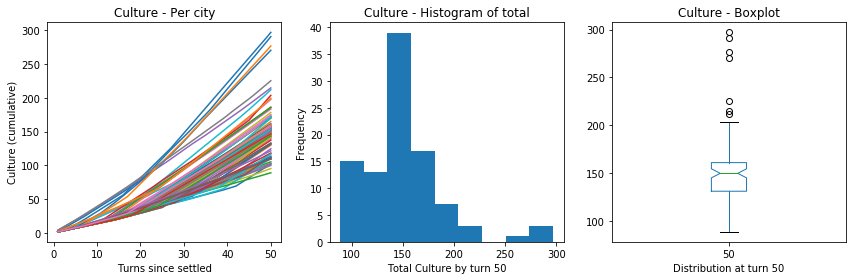


Top 5 culture cities:
        cultureTotal  culturePerTurn    settledByName  population  housing  \
cityId                                                                       
21            297.01            7.79       Wilhelmina           3        7   
51            290.64            7.77  Teddy Roosevelt           4        6   
82            276.91            7.34          Tomyris           6        8   
71            270.48            6.66        Gilgamesh           3        6   
98            225.32            5.42           Trajan           6        9   

       happiness                                     cultureToolTip  
cityId                                                               
21         Happy  +2 from Buildings[NEWLINE]   +1 from Monument[...  
51       Content  +2 from Buildings[NEWLINE]   +1 from Monument[...  
82       Content  +2 from Buildings[NEWLINE]   +1 from Monument[...  
71         Happy  +2 from Worked Tiles[NEWLINE]+1 from Buildings...  
98        

In [8]:
#yields=['Food', 'Production', 'Gold', 'Science', 'Culture', 'Faith']
yld = 'Culture'
columnName = "{}PerTurn".format(yld.lower())
cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                             columns='cityId',
                                                             values=columnName).cumsum()
t50 = cumulativeDf.loc[50]

print("\n{}:-\nsummary statistics:".format(yld))
print("     max: {:.2f}".format(t50.max()))
print("     min: {:.2f}".format(t50.min()))
print("    mean: {:.2f}".format(t50.mean()))
print("  median: {:.2f}".format(t50.median()))
print("     std: {:.2f}".format(t50.std()))
print("\nQuantiles:")
print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
print("\n")

top5 = pd.DataFrame(list(zip(list(t50.nlargest(5).values),
                             list(t50.nlargest(5).index.values)
                        )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
bottom5 = pd.DataFrame(list(zip(list(t50.nsmallest(5).values),
                                list(t50.nsmallest(5).index.values)
                           )
                      ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
axes[0].set_xlabel('Turns since settled')
axes[0].set_ylabel("{} (cumulative)".format(yld))

t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
axes[1].set_xlabel("Total {} by turn 50".format(yld))

t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
axes[2].set_xlabel('Distribution at turn 50')

plt.show()
plt.close()

# Redefining t50 to be the last per turn rows in the dataframe!
t50 = cityPt[cityPt['turns'] == 50]
tCitiesDf = top5.set_index('cityId').join(t50.set_index('cityId'))
bCitiesDf = bottom5.set_index('cityId').join(t50.set_index('cityId'))

yld = yld.lower()
print("\nTop 5 {} cities:".format(yld))
print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
print("\n\nBottom 5 {} cities:".format(yld))
print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Faith


Faith:-
summary statistics:
     max: 350.12
     min: 0.00
    mean: 29.02
  median: 0.00
     std: 67.12

Quantiles:
    0.2  0.4  0.6     0.8
50  0.0  0.0  0.0  37.512




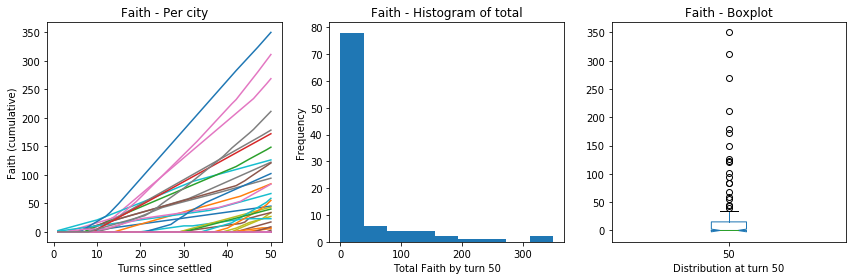


Top 5 faith cities:
        faithTotal  faithPerTurn     settledByName  population  housing  \
cityId                                                                    
51          350.12          8.64   Teddy Roosevelt           4        6   
27          311.27         10.17             Cyrus           5        6   
7           268.84          9.04  Robert the Bruce           4        7   
98          211.41          7.91            Trajan           6        9   
68          178.52          4.52      Genghis Khan           4        8   

       happiness                                       faithToolTip  
cityId                                                               
51       Content  +4 from Worked Tiles[NEWLINE]+4 from GreatWork...  
27         Happy  +5 from Worked Tiles[NEWLINE]+2 from Districts...  
7          Happy  +4 from Worked Tiles[NEWLINE]+4 from GreatWork...  
98         Happy  +5 from Worked Tiles[NEWLINE]+2 from Modifiers...  
68         Happy  +4 from GreatWo

In [9]:
#yields=['Food', 'Production', 'Gold', 'Science', 'Culture', 'Faith']
yld = 'Faith'
columnName = "{}PerTurn".format(yld.lower())
cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                             columns='cityId',
                                                             values=columnName).cumsum()
t50 = cumulativeDf.loc[50]

print("\n{}:-\nsummary statistics:".format(yld))
print("     max: {:.2f}".format(t50.max()))
print("     min: {:.2f}".format(t50.min()))
print("    mean: {:.2f}".format(t50.mean()))
print("  median: {:.2f}".format(t50.median()))
print("     std: {:.2f}".format(t50.std()))
print("\nQuantiles:")
print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
print("\n")

top5 = pd.DataFrame(list(zip(list(t50.nlargest(5).values),
                             list(t50.nlargest(5).index.values)
                        )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
bottom5 = pd.DataFrame(list(zip(list(t50.nsmallest(5).values),
                                list(t50.nsmallest(5).index.values)
                           )
                      ), columns=["{}Total".format(yld.lower()), 'cityId'])

    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
axes[0].set_xlabel('Turns since settled')
axes[0].set_ylabel("{} (cumulative)".format(yld))

t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
axes[1].set_xlabel("Total {} by turn 50".format(yld))

t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
axes[2].set_xlabel('Distribution at turn 50')

plt.show()
plt.close()

# Redefining t50 to be the last per turn rows in the dataframe!
t50 = cityPt[cityPt['turns'] == 50]
tCitiesDf = top5.set_index('cityId').join(t50.set_index('cityId'))
bCitiesDf = bottom5.set_index('cityId').join(t50.set_index('cityId'))

yld = yld.lower()
print("\nTop 5 {} cities:".format(yld))
print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
print("\n\nBottom 5 {} cities:".format(yld))
print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                 'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Population

7
2
4.346938775510204
4.0


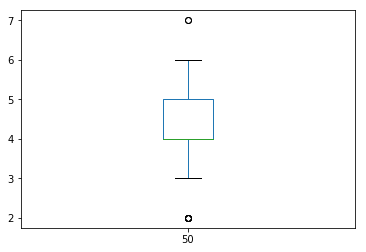

In [10]:
popDf = cityPt[['cityId', 'turns', 'population']].pivot(index='turns',
                                                        columns='cityId',
                                                        values='population')
t50 = popDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box()

In [ ]:
# Code testing how to get turn next pop reached
#df = pd.DataFrame({"A": [1,2,2,2,3],
#                   "B": [1,2,2,3,3],
#                   "C": [1,2,3,3,4],
#                   "D": [1,1,1,2,2]}, index=[1,2,3,4,5])
#print(df)
#maxPop = df.max().max()
#newDf = pd.DataFrame(columns=df.columns.values.tolist(), index=range(1,maxPop+1))
#print(newDf)
#
#for i in range(1,maxPop+1):
#    for j in df.columns.values.tolist():
#        s = df[j]
#        try:
#            s = int(s[s == i].index[0])
#        except IndexError:
#            s = 0
#        newDf.loc[i,j] = s
#print(newDf.astype('int64'))

In [11]:
maxPop = popDf.max().max()
popGrowthDf = pd.DataFrame(columns=popDf.columns.values.tolist(), index=range(1, maxPop + 1))
for i in range(1,maxPop+1):
    for j in popDf.columns.values.tolist():
        s = popDf[j]
        try:
            turnNextPopReached = int(s[s == i].index[0])
        except IndexError:
            # Using NaN messes up types so using 0 to indicate never reached that pop!
            turnNextPopReached = 0
        popGrowthDf.loc[i,j] = turnNextPopReached
popGrowthDf = popGrowthDf.T.astype('int64')
print(popGrowthDf.shape)

(98, 7)


In [12]:
print("Population growth descriptive statistics:\n")
print("Columns represent the population, Rows the descriptive measure")
print("count shows the drop-off in number of city with larger population")
popGrowthStats = pd.DataFrame()
for i in popGrowthDf.columns.values.tolist():
    s = popGrowthDf.loc[:,i]
    s = s[s != 0]
    #print(s.describe())
    popGrowthStats[i] = s.describe()
print(popGrowthStats.round(1))

Population growth descriptive statistics:

Columns represent the population, Rows the descriptive measure
count shows the drop-off in number of city with larger population
          1     2     3     4     5     6     7
count  98.0  98.0  94.0  78.0  50.0  15.0   2.0
mean    1.0   8.4  20.0  30.2  38.5  43.8  46.5
std     0.0   3.1   8.6   9.1   7.6   5.5   0.7
min     1.0   3.0   9.0  15.0  23.0  33.0  46.0
25%     1.0   6.0  13.2  24.0  33.2  41.0  46.2
50%     1.0   8.0  19.0  30.0  39.0  45.0  46.5
75%     1.0   8.0  22.8  36.0  46.0  47.5  46.8
max     1.0  15.0  44.0  50.0  50.0  50.0  47.0


## Housing

10
5
7.5
7.0


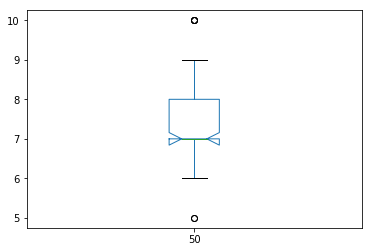

In [13]:
housingDf = cityPt[['cityId', 'turns', 'housing']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='housing')
t50 = housingDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Amenities

3
1
1.5612244897959184
1.0


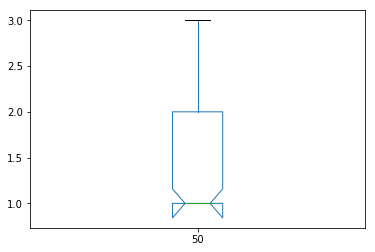

In [14]:
amenitiesDf = cityPt[['cityId', 'turns', 'amenities']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenities')
t50 = amenitiesDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

3
0
1.4285714285714286
1.0


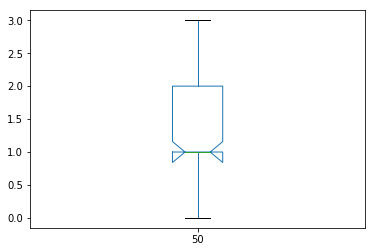

In [15]:
amenitiesNeededDf = cityPt[['cityId', 'turns', 'amenitiesNeeded']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenitiesNeeded')
t50 = amenitiesNeededDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Happiness

In [16]:
happinessDf = cityPt[['cityId', 'turns', 'happiness']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='happiness')
#print(happinessDf.shape)

happinessVals = set([])
for columnName in happinessDf.columns.values.tolist():
    vals = happinessDf[columnName].unique().tolist()
    for item in vals:
        happinessVals.add(item)
#print(happinessVals)

turnsPerHappinessValue = pd.DataFrame()
for columnName in happinessDf.columns.values.tolist():
    for val in happinessVals:
        s = happinessDf[columnName]
        turnsPerHappinessValue.loc[val, columnName] = s[s == val].count()
print("\nPer city number of turns per happiness state:")
print(turnsPerHappinessValue)
print("\nAverage number of turns per happiness state across all the cities:")
print(turnsPerHappinessValue.T.mean())




Per city number of turns per happiness state:
              1     2     3     4     5     6     7     8     9     10  ...   \
Happy       50.0  49.0  15.0  50.0  12.0  20.0  12.0  41.0  34.0  13.0  ...    
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
Displeased   0.0   0.0   9.0   0.0  12.0   0.0   0.0   0.0   0.0  13.0  ...    
Content      0.0   1.0  26.0   0.0  26.0  30.0  38.0   9.0  16.0  24.0  ...    

              89    90    91    92    93    94    95    96    97    98  
Happy       50.0  50.0   8.0  15.0  18.0  50.0   8.0  17.0  15.0  16.0  
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Displeased   0.0   0.0  20.0   9.0   0.0   0.0   5.0   1.0   3.0  11.0  
Content      0.0   0.0  22.0  26.0  32.0   0.0  37.0  32.0  32.0  23.0  

[4 rows x 98 columns]

Average number of turns per happiness state across all the cities:
Happy         25.316327
Ecstatic       0.030612
Displeased     4.091837
Content       20.561224
